# H&M Personalized Fashion Recommendations

### Dataset Source: Kaggle
### Link: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations

### Overview

H&M Group is a family of brands and businesses with 53 online markets and approximately 4,850 stores. Our online store offers shoppers an extensive selection of products to browse through. But with too many choices, customers might not quickly find what interests them or what they are looking for, and ultimately, they might not make a purchase. To enhance the shopping experience, product recommendations are key. More importantly, helping customers make the right choices also has a positive implications for sustainability, as it reduces returns, and thereby minimizes emissions from transportation.

In this competition, H&M Group invites you to develop product recommendations based on data from previous transactions, as well as from customer and product meta data. The available meta data spans from simple data, such as garment type and customer age, to text data from product descriptions, to image data from garment images.

There are no preconceptions on what information that may be useful – that is for you to find out. If you want to investigate a categorical data type algorithm, or dive into NLP and image processing deep learning, that is up to you.

### Dataset Description:

For this challenge you are given the purchase history of customers across time, along with supporting metadata. Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.

Files
* articles.csv - detailed metadata for each article_id available for purchase
* customers.csv - metadata for each customer_id in dataset
* transactions_train.csv - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

In [12]:
import numpy as np
import pandas as pd
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.display.float_format = '{:.4f}'.format

## transactions_train.csv

Loading Data via S3

In [11]:
bucket='ads-508-group-6-raw'
data_key = 'transactions_train.csv'

s3 = boto3.client('s3')
transactions_obj = s3.get_object(Bucket = bucket, Key = data_key)

transactions_df = pd.read_csv(transactions_obj['Body'])

Loading Data Locally

In [14]:
transactions_df = pd.read_csv("C:\\Users\\garyb\\OneDrive\\Documents\\GitHub\\recommendation-engine\\data\\transactions_train.csv")

In [33]:
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.0508,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.0305,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.0152,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.0169,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.0169,2


In [34]:
transactions_df.describe()

,article_id,price,sales_channel_id
count,31788324.0000,31788324.0000,31788324.0000
mean,696227219.0051,0.0278,1.7040
std,133448003.4874,0.0192,0.4565
min,108775015.0000,0.0000,1.0000
25%,632803008.0000,0.0158,1.0000
50%,714582003.0000,0.0254,2.0000
75%,786524001.0000,0.0339,2.0000
max,956217002.0000,0.5915,2.0000


In [16]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [17]:
transactions_df.nunique()

t_dat                   734
customer_id         1362281
article_id           104547
price                  9857
sales_channel_id          2
dtype: int64

In [18]:
transactions_df.shape

(31788324, 5)

In [19]:
transactions_df.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

### Categorical EDA

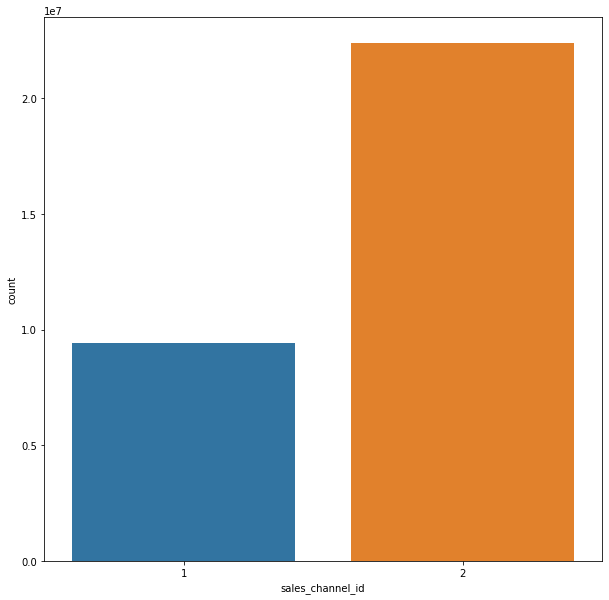

In [15]:
plt.figure(figsize=(10,10))
ax = sns.countplot(data = transactions_df, x = 'sales_channel_id')

In [16]:
print(transactions_df.sales_channel_id.value_counts(normalize = True))

2    0.704028
1    0.295972
Name: sales_channel_id, dtype: float64


### Numerical EDA

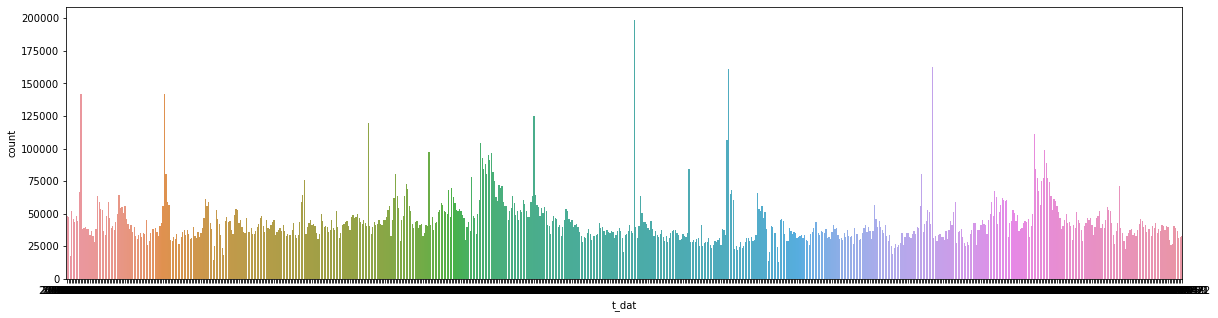

In [20]:
plt.figure(figsize=(20,5))
ax = sns.countplot(data = transactions_df, x = 't_dat')

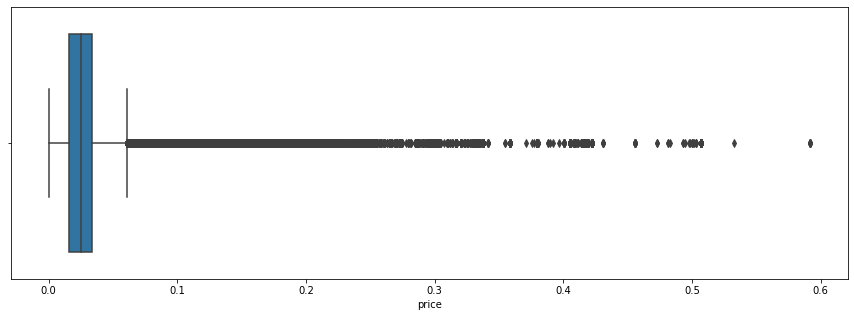

In [20]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data = transactions_df, x = 'price')

## customers.csv

Loading Data from S3

In [21]:
bucket='ads-508-group-6-raw'
data_key = 'customers.csv'

s3 = boto3.client('s3')
customers_obj = s3.get_object(Bucket = bucket, Key = data_key)

customers_df = pd.read_csv(customers_obj['Body'])

Load Data Locally

In [24]:
customers_df = pd.read_csv("C:\\Users\\garyb\\OneDrive\\Documents\\GitHub\\recommendation-engine\\data\\customers.csv")

In [25]:
customers_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [35]:
customers_df.describe()

,FN,Active,age
count,476930.0000,464404.0000,1356119.0000
mean,1.0000,1.0000,36.3870
std,0.0000,0.0000,14.3136
min,1.0000,1.0000,16.0000
25%,1.0000,1.0000,24.0000
50%,1.0000,1.0000,32.0000
75%,1.0000,1.0000,49.0000
max,1.0000,1.0000,99.0000


In [36]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [37]:
customers_df.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

In [38]:
customers_df.shape

(1371980, 7)

In [39]:
customers_df.isnull().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

### Categorical EDA

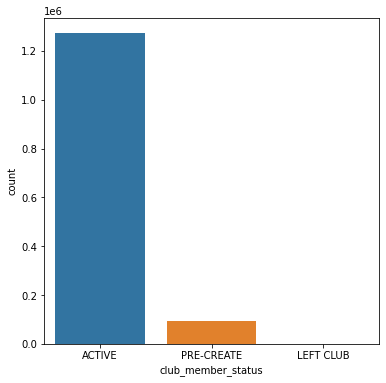

In [42]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data = customers_df, x = 'club_member_status')

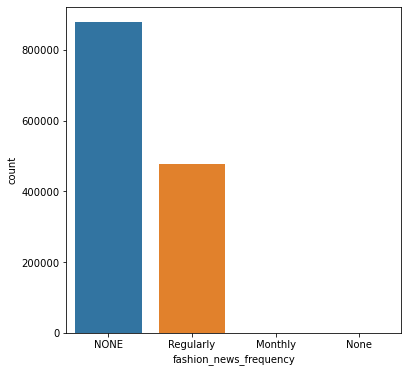

In [43]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data = customers_df, x = 'fashion_news_frequency')

### Numerical EDA

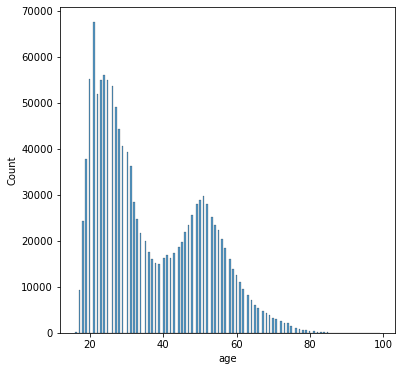

In [45]:
plt.figure(figsize=(6,6))
ax = sns.histplot(data = customers_df, x = 'age')

## articles.csv

Loading Data from S3

In [27]:
bucket='ads-508-group-6-raw'
data_key = 'articles.csv'

s3 = boto3.client('s3')
articles_obj = s3.get_object(Bucket = bucket, Key = data_key)

articles_df = pd.read_csv(articles_obj['Body'])

Loading Data Locally

In [50]:
articles_df = pd.read_csv("C:\\Users\\garyb\\OneDrive\\Documents\\GitHub\\recommendation-engine\\data\\articles.csv")

In [51]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [52]:
articles_df.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000
mean,698424569.0969,698424.5634,234.8619,1009515.0757,32.2338,3.2062,7.8080,4532.7778,3.1715,42.6642,1010.4383
std,128462381.3362,128462.3844,75.0493,22413.5858,28.0862,1.5638,5.3767,2712.6920,4.3532,23.2601,6.7310
min,108775015.0000,108775.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,1201.0000,1.0000,2.0000,1001.0000
25%,616992501.0000,616992.5000,252.0000,1010008.0000,9.0000,2.0000,4.0000,1676.0000,1.0000,20.0000,1005.0000
50%,702213001.5000,702213.0000,259.0000,1010016.0000,14.0000,4.0000,5.0000,4222.0000,2.0000,46.0000,1009.0000
75%,796703001.7500,796703.0000,272.0000,1010016.0000,52.0000,4.0000,11.0000,7389.0000,4.0000,61.0000,1017.0000
max,959461001.0000,959461.0000,762.0000,1010029.0000,93.0000,7.0000,20.0000,9989.0000,26.0000,97.0000,1025.0000


In [53]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [54]:
articles_df.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [32]:
articles_df.shape

(105542, 25)

In [33]:
articles_df.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

### Shutting Down Kernel To Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}